In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

from typing import Union, List, Tuple, Dict, Set

vector normalization

In [ ]:
vectors = np.array([[ 7.,  8.,  5.,  5.],
                    [ 9.,  8., 10.,  8.],
                    [10.,  8.,  8.,  6.]])
vectors

In [ ]:
import torch.nn.functional as F

## Task 1
Write function that normalize all vectors. As an output return torch.tensor

### help

In [ ]:
# 1. use torch.nn.functional module to normalize (there are normalize function)
# 2. don`t forget to cast types

### continue work

In [ ]:
# YOUR CODE HERE
def normalize_vectors(vectors: Union[List[Union[int, float]],
                                     np.array,
                                     torch.tensor]) -> torch.tensor:
  pass

In [ ]:
normed_vectors = normalize_vectors(vectors)

assert torch.norm(normed_vectors, dim=1).sum().item() == 3
assert normed_vectors.dtype == torch.float64

calculate vector similarity

## Task 2
Write on pure numpy function that measure vector distance between two vectors
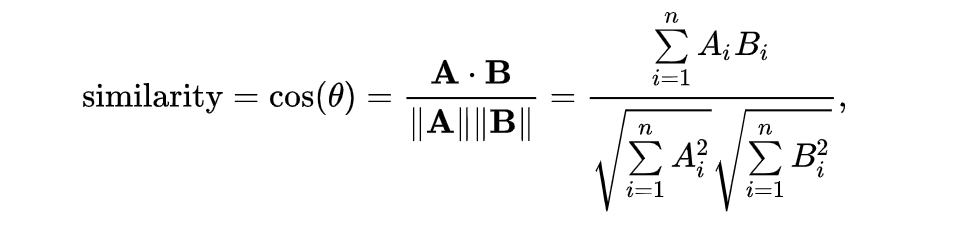

In [ ]:
from numpy import dot
from numpy.linalg import norm

In [ ]:
# YOUR CODE HERE
def cos_similarity(a: np.array, b: np.array) -> float:
  pass

In [ ]:
cos_sim_1 = cos_similarity(normed_vectors[0], normed_vectors[1])
cos_sim_2 = cos_similarity(normed_vectors[1], normed_vectors[2])

assert cos_sim_1 < cos_sim_2
assert cos_sim_1 > 0.96
assert cos_sim_2 > 0.98

train on our dataset unsupervised fasttext

In [ ]:
!pip install fasttext

In [ ]:
# !wget
# !unzip data.zip

lookup and explore our data 

In [ ]:
import fasttext

In [ ]:
parse_labels = ['__label__NORMAL','__label__INSULT','__label__THREAT','__label__OBSCENITY']

In [ ]:
train = pd.read_csv('data/train', sep='\t', names=['id','target','temp1','temp2','comment'], index_col=0)

parse_labels = ['__label__NORMAL','__label__INSULT','__label__THREAT','__label__OBSCENITY']

mask = train['comment'].isin(parse_labels)
train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask]['comment']
train.loc[mask,'comment'] = np.nan

for t in ['temp1','temp2']:
    mask = train[t].isin(parse_labels)
    train.loc[mask,'target'] = train[mask]['target'] + ',' + train[mask][t]
    train.loc[mask,t] = np.nan
    train.loc[~train[t].isna(),'comment'] = train[~train[t].isna()][t]

train[['оскорбление','другое','непростойность','угроза']] = train['target'].str.get_dummies(sep=',')

train = train[['другое','оскорбление','непростойность','угроза', 'comment']]
train.sample(7)

## Task 3
Initialize variables for texts and targets from train data

In [ ]:
# YOUR CODE HERE
texts = None
targets = None

In [ ]:
assert texts.shape[0] == 148775
assert targets.shape[1] == 4
assert texts.shape[0] == targets.shape[0]

## Task 4
Create file `messages_unsupervised.txt`, that will contain all messages separeted by the `\n` symbol

In [ ]:
# YOUR CODE HERE

In [ ]:
import os

assert 'messages_unsupervised.txt' in os.listdir('./')

In [ ]:
%%time
ft_vectors = fasttext.train_unsupervised('messages_unsupervised.txt', minn=3,maxn=5, dim=50)

In [ ]:
ft_vectors.get_nearest_neighbors('дебил')

Let`s visualize our vectors

In [ ]:
!pip install MulticoreTSNE > /dev/null

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split


from sklearn.decomposition import TruncatedSVD
from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
print(len(ft_vectors.words))
top3k = ft_vectors.words[:3000]
top3k[:10]

## Task 5
initialize variable with all vectors, that are in top 3000 for frequency

In [ ]:
# YOUR CODE HERE
top3k_vectors = None

In [ ]:
%%time
tsne_emb = TSNE(n_components=2,
                n_iter=2000,
                n_jobs=-1,
                random_state=42).fit_transform(np.array(top3k_vectors))

In [ ]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save", title="TSNE representation of FastText vectors (top 3k words)")

source = ColumnDataSource(data=dict(x1=tsne_emb[:,0], x2=tsne_emb[:,1], names=top3k))

p.scatter(x="x1", y="x2", source=source, size=5)

words = LabelSet(x="x1", y="x2", text="names", source=source,
                y_offset=6, text_font_size="6pt", 
                 text_color="#555555", text_align="center")

p.add_layout(words)

show(p)

Now try to preprocess texts!<br>
write function to preprocess texts. You can do whatever you want:
 - delete stop words
 - delete punctuation
 - lematize words
 - stemming
 - lower texts

 After that you can explore texts and their representation

# Part 2

In [ ]:
!pip install datasets > /dev/null

In [ ]:
import datasets

sentiment analysis dataset load

In [ ]:
text_dataset = datasets.load_dataset("imdb")

In [ ]:
pd.DataFrame(text_dataset['train'], columns=['label', 'text'])['label'].hist();

In [ ]:
df = pd.DataFrame(text_dataset['train'], columns=['label', 'text'])

## Task 6
Initialize new df as half of randomly chosen rows of df

In [ ]:
# YOUR CODE HERE
df = None

In [ ]:
df['label'].hist();

explore how to load predifined weights in vectors

In [ ]:
some_vectors = torch.rand((10,50), dtype=torch.float32)

In [ ]:
custom_layer = nn.Embedding(10, 50)

In [ ]:
custom_layer.weight = nn.Parameter(some_vectors.clone().detach().requires_grad_(True))

In [ ]:
import gensim.downloader

In [ ]:
list(gensim.downloader.info()['models'].keys())

In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-100')

In [ ]:
glove_vectors.vectors.shape

In [ ]:
list(glove_vectors.vocab.keys())[250:300]

## Task 7
Initialize loaded weights from gensim to some embedding matrix

In [ ]:
# YOUR CODE HERE

In [ ]:
assert embedding_matrix.shape == (1193514, 100)
assert embedding_matrix[23].sum() < -4.45
assert cos_similarity(embedding_matrix[42], embedding_matrix[23]) < 0.57

Let`s get back to explore data

In [ ]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

In [ ]:
l = float('-inf')
l = list()
for text in tqdm(df['text']):
    l.append(len(tokenizer.tokenize(text.lower())))

In [ ]:
print(pd.Series(l).describe())
pd.Series(l).plot()

it can be seen that 90% of the texts do not exceed 1500 tokens. Let's take the quantile 0.95 with a margin and initialize the variable max_len with this value.

## Task 8
Take the quantile 0.95 of `l` with a margin and initialize the variable max_len with this value.

In [ ]:
# YOUR CODE HERE
max_len = None
max_len

In [ ]:
from collections import Counter

In [ ]:
words = list()
for text in tqdm(df['text']):
    words.extend(tokenizer.tokenize(text.lower()))
index2word = dict(enumerate((word[0] for word in Counter(words).most_common()), start=1))
index2word[0] = '<UNK>'
word_index = {word: ind for ind, word in index2word.items()}

In [ ]:
len(word_index)

In [ ]:
def load_w2v(words_dict, w2v, embed_size=100, max_features=100_000):
  emb_matrix = np.zeros((min(max_features, len(words_dict)), embed_size))
  for word, ind in words_dict.items():
      if ind >= max_features:
        break
      try:
        embedding_vector = w2v.get_vector(word)
      except KeyError:
        embedding_vector = None
      if embedding_vector is not None:
        emb_matrix[ind] = embedding_vector
  return normalize_vectors(emb_matrix)

In [ ]:
embedding_matrix = load_w2v(word_index, glove_vectors)

In [ ]:
class CustomDataset:
  def __init__(self, data, targets, tokenize, word2index, max_len=max_len):
    self.data = data
    self.targets = targets
    self.tokenize = tokenize
    self.word2index = word2index

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data[idx]
    label = self.targets[idx]

    input_ids = np.zeros((int(max_len),))
    row = self.tokenize(text.lower())
    for ind, word in enumerate(row):
      if ind < max_len - 1:
        input_ids[ind] = self.word2index.get(word, 0)
    
    return {
        'text': torch.tensor(input_ids, dtype=torch.long),
        'label': torch.tensor(label, dtype=torch.long)
    }

## Task 9
Create `train_dataset` variable as instance of class CustomDataset

In [ ]:
# YOUR CODE HERE

In [ ]:
train_dataset[3]

In [ ]:
class ConvNeuralNet(nn.Module):
    def __init__(self, embedding_matrix, embed_size,
                 do_rate1=0.5, n_classes=2):
        super(ConvNeuralNet, self).__init__()

        self.vocab_size = embedding_matrix.shape[0]
        self.embedding_size = embed_size
        self.kernel_num = 128
        self.kernels_sizes = [2, 4, 8]
        
        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (K, embed_size)) for K in self.kernels_sizes])
        self.dropout = nn.Dropout2d(do_rate1)
        self.fc1 = nn.Linear(len(self.kernels_sizes) * self.kernel_num, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        
        x = torch.cat(x, 1)
        
        x = self.dropout(x)
        logit = self.fc1(x)
        return logit

## Task 10
Fill the code with calculation of making prediction, calculating loss, backpropogation, optimization

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

In [ ]:
# YOUR CODE HERE
def train(dataloader, optimizer=optimizer, criterion=criterion):
    model.train()
    total_acc, total_count, total_loss = 0, 0, 0
    start_time = time.time()

    for idx, batch in enumerate(tqdm(dataloader)):
        text = batch['text'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        # FILL HERE
        # loss = FILL HERE
        # FILL HERE
        total_loss += loss
        # FILL HERE
        predited_label = predited_label.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        total_acc += accuracy(predited_label, label)
        total_count += len(label)
    elapsed = time.time() - start_time
    print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}| loss {:8.3f}'.format(epoch, idx,
                                                            len(dataloader),
                                                            total_acc/total_count,
                                                            total_loss/total_count
                                                            ))
    total_acc, total_count = 0, 0
    start_time = time.time()

In [ ]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count, total_loss = 0, 0, 0

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            text = batch['text'].to(device)
            label = batch['label'].to(device)
            predited_label = model(text)
            total_loss += criterion(predited_label, label)
            predited_label = predited_label.detach().cpu().numpy()
            label = label.to('cpu').numpy()
            total_acc += accuracy(predited_label, label)
            total_count += len(label)
    print('| epoch {:3d} | {:5d}/{:5d} batches '
    '| accuracy {:8.3f}| loss {:8.3f}'.format(epoch, idx,
                                              len(dataloader),
                                              total_acc/total_count,
                                              total_loss/total_count)
    )
    return total_acc/total_count

In [ ]:
def accuracy(probs, targets):
    outputs = np.argmax(probs, axis=1)
    return np.sum(outputs == targets)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')

In [ ]:
ConvNeuralNet(embedding_matrix, 100)

In [ ]:
from torch.utils.data.dataset import random_split
import time

# гиперпараметры
EPOCHS = 7
LR = 3e-4 
BATCH_SIZE = 32

model = ConvNeuralNet(embedding_matrix, 100).to(device)

total_accu = None

num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True)


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    if epoch == 4:  # разморозим веса наших эмбеддингов, чтобы немного донастроить модель под нашу задачу
      model.embedding.weight.requires_grad = True
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

In [ ]:
positive_comment = 'This movie is awesome!'
negative_comment = 'This movie is very very bad!'
neutral_comment = 'This is so-so'

_dataset = CustomDataset([positive_comment, negative_comment, neutral_comment], [0] * 3, tokenizer.tokenize, word_index)
_dataloader = torch.utils.data.DataLoader(_dataset, batch_size=32)

_x = next(iter(_dataloader))['text'].to(device)
probs = torch.softmax(model(_x), 1).detach().cpu().numpy()

print(np.round(probs, 3))

print(f'Probability of "{positive_comment}" to be positive -- {probs[0][1]}')
print(f'Probability of "{negative_comment}" to be positive -- {probs[1][0]}')
print(f'Probability of "{neutral_comment}" to be positive -- {probs[2][0]}')

del _dataset, _dataloader 